## given isolated clusters of drifters, create contours of the watersheds and find the areas of the contours considering a spherical earth.

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
from scipy.ndimage import gaussian_filter
from shapely.geometry import Polygon
import pyproj

In [110]:
# old clusters
SE_Pacific = pd.read_csv('cluster_0_data.csv')
Europe = pd.read_csv('cluster_3_data.csv')
SW_SA = pd.read_csv('cluster_5_data.csv')
S_Pacific_Islands = pd.read_csv('cluster_6_data.csv')
Alaska_Canada = pd.read_csv('cluster_7_data.csv')
Brazil = pd.read_csv('cluster_10_data.csv')
Caribbean_Florida = pd.read_csv('cluster_12_data.csv')
Indian_Ocean = pd.read_csv('cluster_14_data.csv')
Asia = pd.read_csv('cluster_16_data.csv')

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [111]:
# new clusters
Asia_coords = pd.read_csv('Asia_coords.csv')
Australia_coords = pd.read_csv('Australia_coords.csv')
Brazil_coords = pd.read_csv('Brazil_coords.csv')
Caribbean_coords = pd.read_csv('Caribbean_coords.csv')
Chile_coords = pd.read_csv('Chile_coords.csv')
E_Africa_coords = pd.read_csv('E_Africa_coords.csv')
Equatorial_Pacific_coords = pd.read_csv('Equatorial_Pacific_coords.csv')
Europe_coords = pd.read_csv('Europe_coords.csv')
India_coords = pd.read_csv('India_coords.csv')
Oceania_coords = pd.read_csv('Oceania_coords.csv')
PNW_coords = pd.read_csv('PNW_coords.csv')
W_Africa_coords = pd.read_csv('W_Africa_coords.csv')

#### sort cluster trajectories into their time based groups using functions: 1 month, 3 months, 6 months, 1 year

In [112]:
def one_to_beach(cluster):
    
    # one month in seconds
    one = 2629800
    
    # if the trajectory is long enough (i.e, if the time in the trajectory is greater than 1 month,
    if (cluster['time_to_beach'] >= one).any():
        
        # append all times less than one month to the filtered cluster.
        filtered_cluster = cluster[cluster['time_to_beach'] <= one]
    return filtered_cluster

# repeat for the other time based groups

In [113]:
def three_to_beach(cluster):

    three = 7776000
    
    if (cluster['time_to_beach'] >= three).any():
        filtered_cluster = cluster[cluster['time_to_beach'] <= three]
    return filtered_cluster

In [114]:
def six_to_beach(cluster):

    six = 15638400
    
    if (cluster['time_to_beach'] >= six).any():
        filtered_cluster = cluster[cluster['time_to_beach'] <= six]
    return filtered_cluster

In [115]:
def year_to_beach(cluster):

    year = 31536000
    
    if (cluster['time_to_beach'] >= year).any():
        filtered_cluster = cluster[cluster['time_to_beach'] <= year]
    return filtered_cluster

### plot the density heatmap of all clusters, as well as a blurred watershed contour derived from the gaussian blurred version of the heatmap for aesthetic purposes

In [116]:
# using latitude and longitude data derived from the filtered clusters, we will create a density heatmap.

def plot_density_heatmap(latitudes, longitudes, lat_bins, lon_bins, ax, cmap='viridis'):

    # this creates a 2D histogram of the lats and lons,
    heatmap_data, lat_edges, lon_edges = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)
    
    # normalized to 1. this makes it a density plot.  this is done with the formula (value - min)/(max - min)
    heatmap_data_normalized = (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

    # the centers are calculated as the midpoints of each bin, which are used for the coordinates for plotting. _edges[:-1] and _edges[:1] 
    # represent the start and end of each bin, and when the average is taken, we get the center of each bin.
    lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
    lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2

    # this creates the plot using the data. _centers are the grid coordinates, heatmap_data_normalized is the normalized density data, and PlateCarree is the projection system.
    mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data_normalized, cmap=cmap, transform=ccrs.PlateCarree())

    # plotting the contours of the specified data. "levels" specifies where the contour should be drawn.
    contour = plt.contour(lon_centers, lat_centers, heatmap_data_normalized, levels=[0.05], colors='white', linestyles='solid', transform=ccrs.PlateCarree())

    return mesh, contour

In [117]:
def convert_to_numeric(df, columns):
    for column in columns:
        # for each column, convert the data into a numeric value. if there is not a number, set to NaN
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

In [118]:
# define the grid cells
n_lons, n_lats = 135, 85

# define the bins
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

#dataframes = {
#    'S_Pacific_Islands': 'cluster_6_data.csv',    
#    'Indian_Ocean': 'cluster_14_data.csv',    
#    'SE_Pacific': 'cluster_0_data.csv',
#    'SW_SA': 'cluster_5_data.csv',
#    'Brazil': 'cluster_10_data.csv',    
#    'Europe': 'cluster_3_data.csv',
#    'Caribbean_Florida': 'cluster_12_data.csv',    
#    'Asia': 'cluster_16_data.csv',
#    'Alaska_Canada': 'cluster_7_data.csv'
#}


dataframes = {
    'Asia': 'Asia_coords.csv',    
    'Australia': 'Australia_coords.csv',    
    'Brazil': 'Brazil_coords.csv',
    'Caribbean': 'Caribbean_coords.csv',
    'Chile': 'Chile_coords.csv',    
    'E_Africa': 'E_Africa_coords.csv',
    'Equatorial_Pacific': 'Equatorial_Pacific_coords.csv',    
    'Europe': 'Europe_coords.csv',
    'India': 'India_coords.csv',
    'Oceania': 'Oceania_coords.csv',
    'PNW': 'PNW_coords.csv',
    'W_Africa': 'W_Africa_coords.csv'
}


In [134]:
def preprocess_data(df):
    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df.dropna(subset=['lat', 'lon'], inplace=True)

    return df

In [135]:
def year_area(cluster_file):
    data = pd.read_csv(cluster_file)
    data = year_to_beach(data)
    data = preprocess_data(data)

    latitudes = data['lat'].values
    longitudes = data['lon'].values
    heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

    lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
    lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
    mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data, cmap='viridis', transform=ccrs.PlateCarree())

    contour = ax.contour(lon_centers, lat_centers, heatmap_data, levels=[0.05], colors='white', linestyles='solid', transform=ccrs.PlateCarree())

    total_area = 0
    for i in range(len(contour.collections)):
        contour_collection = contour.collections[i]
        paths = contour_collection.get_paths()
        for path in paths:
            vertices = path.vertices
            if len(vertices) >= 3:  # check for at least 3 vertices
                polygon = Polygon(vertices)  # create a polygon
                
                # create a GeoDataFrame to handle projection and area calculation
                gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[polygon])  # EPSG:4326 is lat/lon
                
                # reproject to UTM (Universal Transverse Mercator projection)
                gdf = gdf.to_crs(epsg=3395)  # EPSG:3395 is World Mercator (meters)
                
                # add the area of the projected polygon (in square meters)
                total_area += gdf.geometry.area[0]
                
    total_area = total_area / 1_000_000  # 1,000,000 square meters in a square kilometer
    
    
    return total_area

In [136]:
def six_area(cluster_file):
    data = pd.read_csv(cluster_file)
    data = six_to_beach(data)
    data = preprocess_data(data)

    latitudes = data['lat'].values
    longitudes = data['lon'].values
    heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

    lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
    lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
    mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data, cmap='viridis', transform=ccrs.PlateCarree())

    contour = ax.contour(lon_centers, lat_centers, heatmap_data, levels=[0.05], colors='white', linestyles='solid', transform=ccrs.PlateCarree())

    total_area = 0
    for i in range(len(contour.collections)):
        contour_collection = contour.collections[i]
        paths = contour_collection.get_paths()
        for path in paths:
            vertices = path.vertices
            if len(vertices) >= 3:  # check for at least 3 vertices
                polygon = Polygon(vertices)  # create a polygon
                
                # create a GeoDataFrame to handle projection and area calculation
                gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[polygon])  # EPSG:4326 is lat/lon
                
                # reproject to UTM (Universal Transverse Mercator projection)
                gdf = gdf.to_crs(epsg=3395)  # EPSG:3395 is World Mercator (meters)
                
                # add the area of the projected polygon (in square meters)
                total_area += gdf.geometry.area[0]
                
    total_area = total_area / 1_000_000  # 1,000,000 square meters in a square kilometer
    
    
    return total_area

In [137]:
def three_area(cluster_file):
    data = pd.read_csv(cluster_file)
    data = three_to_beach(data)
    data = preprocess_data(data)

    latitudes = data['lat'].values
    longitudes = data['lon'].values
    heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

    lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
    lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
    mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data, cmap='viridis', transform=ccrs.PlateCarree())

    contour = ax.contour(lon_centers, lat_centers, heatmap_data, levels=[0.05], colors='white', linestyles='solid', transform=ccrs.PlateCarree())

    total_area = 0
    for i in range(len(contour.collections)):
        contour_collection = contour.collections[i]
        paths = contour_collection.get_paths()
        for path in paths:
            vertices = path.vertices
            if len(vertices) >= 3:  # check for at least 3 vertices
                polygon = Polygon(vertices)  # create a polygon
                
                # create a GeoDataFrame to handle projection and area calculation
                gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[polygon])  # EPSG:4326 is lat/lon
                
                # reproject to UTM (Universal Transverse Mercator projection)
                gdf = gdf.to_crs(epsg=3395)  # EPSG:3395 is World Mercator (meters)
                
                # add the area of the projected polygon (in square meters)
                total_area += gdf.geometry.area[0]
                
    total_area = total_area / 1_000_000  # 1,000,000 square meters in a square kilometer
    
    
    return total_area

In [138]:
def one_area(cluster_file):
    data = pd.read_csv(cluster_file)
    data = one_to_beach(data)
    data = preprocess_data(data)

    latitudes = data['lat'].values
    longitudes = data['lon'].values
    heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

    lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
    lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
    mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data, cmap='viridis', transform=ccrs.PlateCarree())

    contour = ax.contour(lon_centers, lat_centers, heatmap_data, levels=[0.05], colors='white', linestyles='solid', transform=ccrs.PlateCarree())

    total_area = 0
    for i in range(len(contour.collections)):
        contour_collection = contour.collections[i]
        paths = contour_collection.get_paths()
        for path in paths:
            vertices = path.vertices
            if len(vertices) >= 3:  # check for at least 3 vertices
                polygon = Polygon(vertices)  # create a polygon
                
                # create a GeoDataFrame to handle projection and area calculation
                gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[polygon])  # EPSG:4326 is lat/lon
                
                # reproject to UTM (Universal Transverse Mercator projection)
                gdf = gdf.to_crs(epsg=3395)  # EPSG:3395 is World Mercator (meters)
                
                # add the area of the projected polygon (in square meters)
                total_area += gdf.geometry.area[0]
                
    total_area = total_area / 1_000_000  # 1,000,000 square meters in a square kilometer
    
    
    return total_area

In [139]:
dataframes = {
    'S_Pacific_Islands': 'cluster_6_data.csv',    
    'Indian_Ocean': 'cluster_14_data.csv',    
    'SE_Pacific': 'cluster_0_data.csv',
    'SW_SA': 'cluster_5_data.csv',
    'Brazil': 'cluster_10_data.csv',    
    'Europe': 'cluster_3_data.csv',
    'Caribbean_Florida': 'cluster_12_data.csv',    
    'Asia': 'cluster_16_data.csv',
    'Alaska_Canada': 'cluster_7_data.csv'
}

/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes

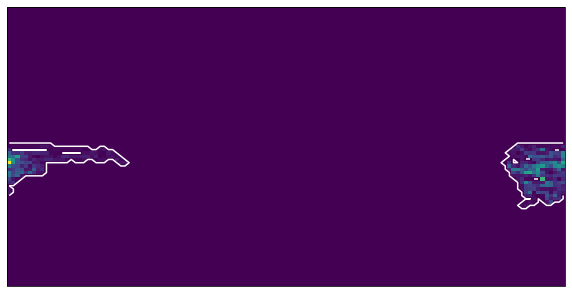

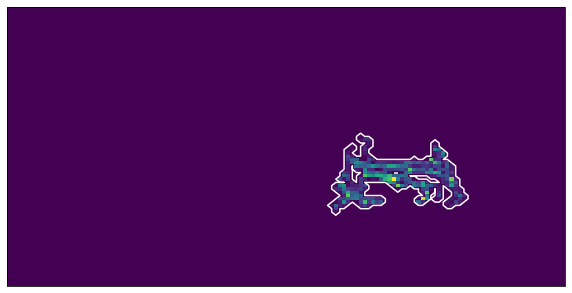

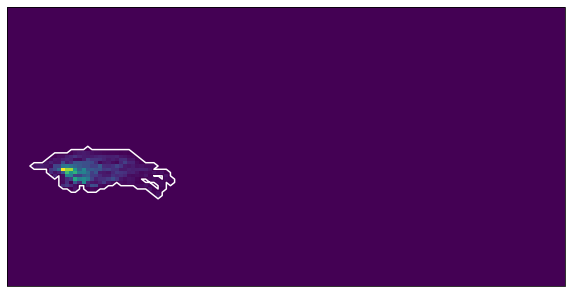

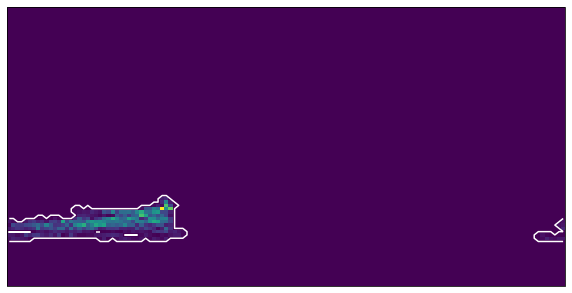

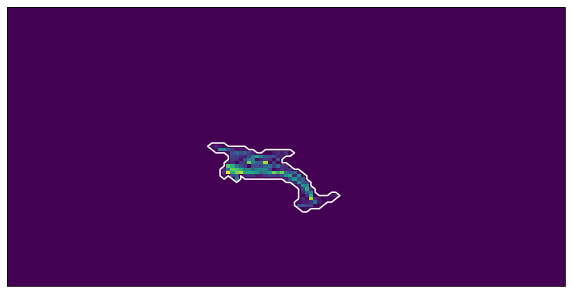

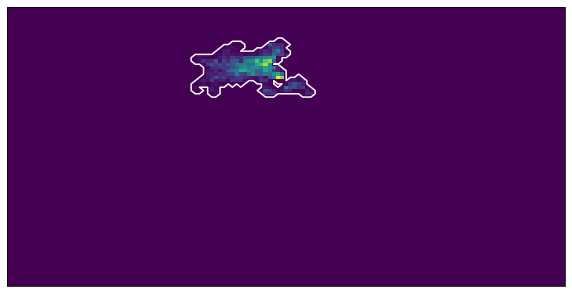

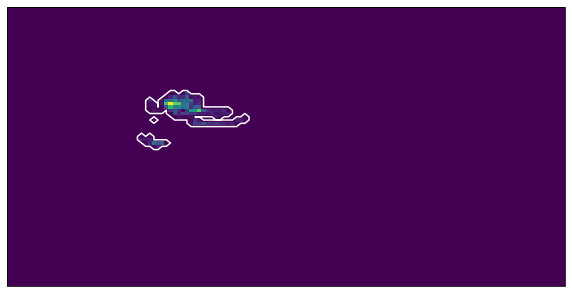

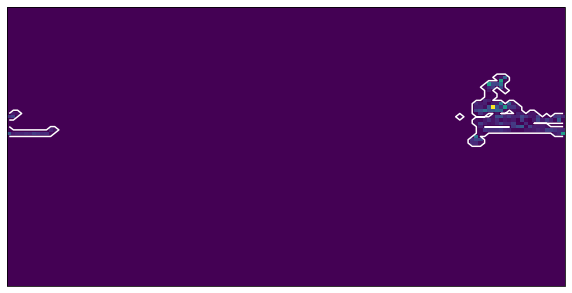

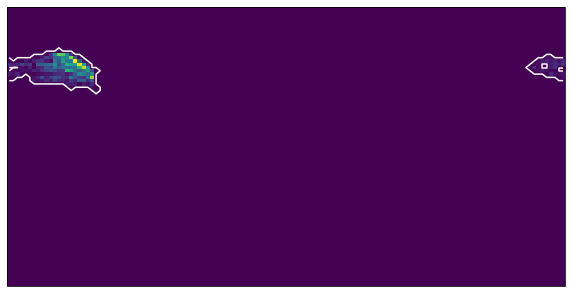

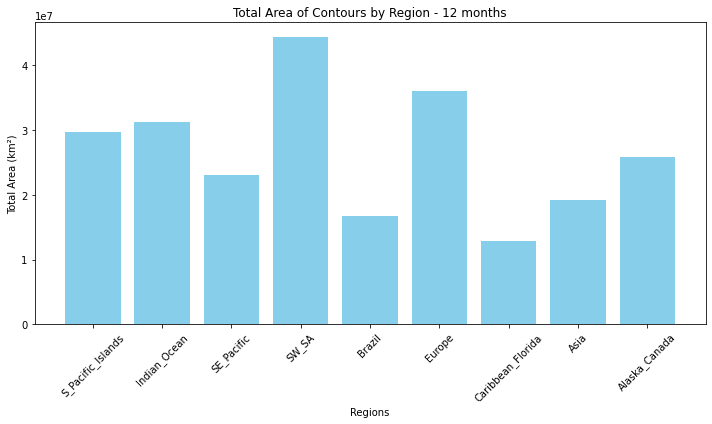

In [144]:
# calculate areas of one year trajectories
area_results = {}
for region, file in dataframes.items():
    total_area = year_area(file)
    area_results[region] = total_area

# create plot
plt.figure(figsize=(10, 6))
plt.bar(area_results.keys(), area_results.values(), color='skyblue')
plt.xlabel('Regions')
plt.ylabel('Total Area (km²)')
plt.title('Total Area of Contours by Region - 12 months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes

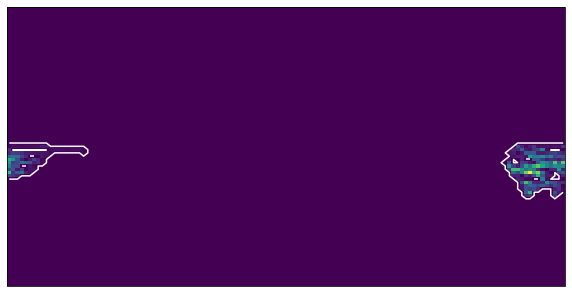

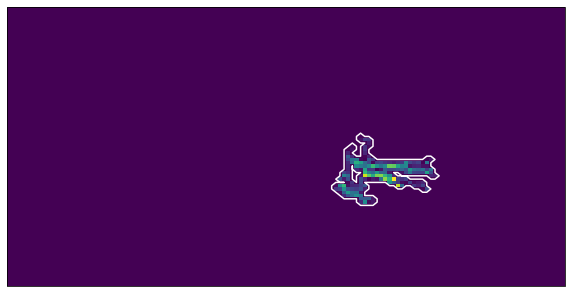

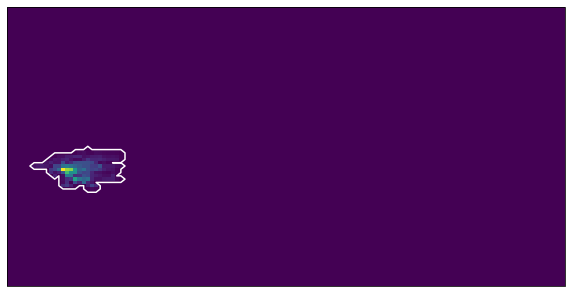

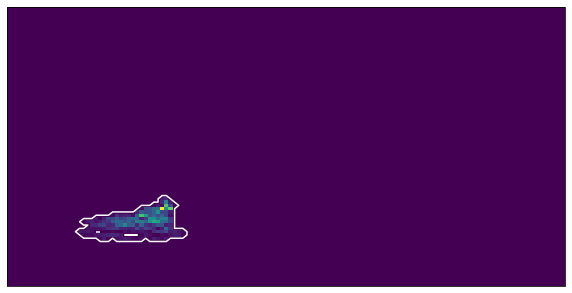

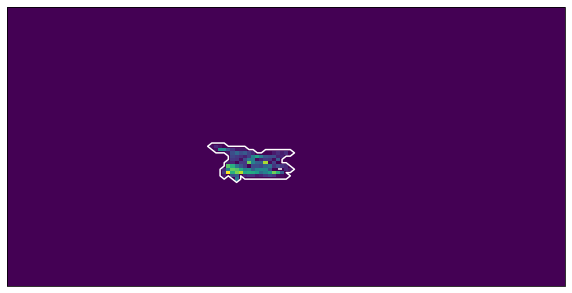

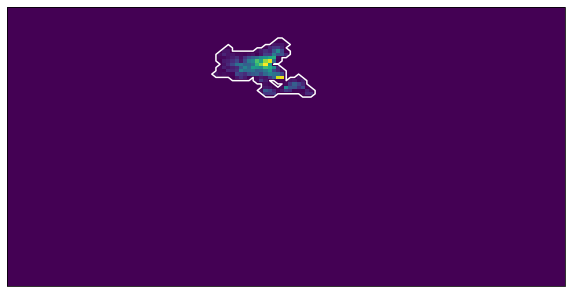

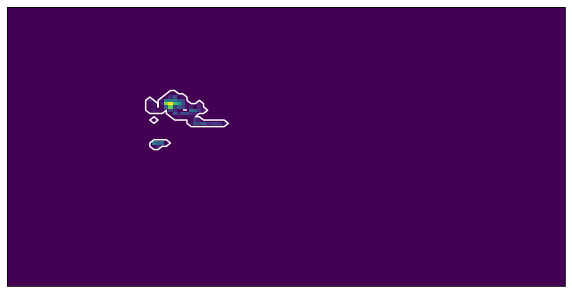

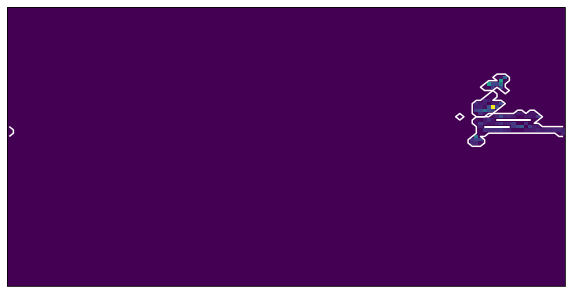

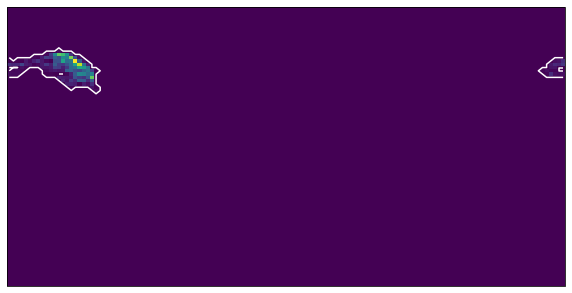

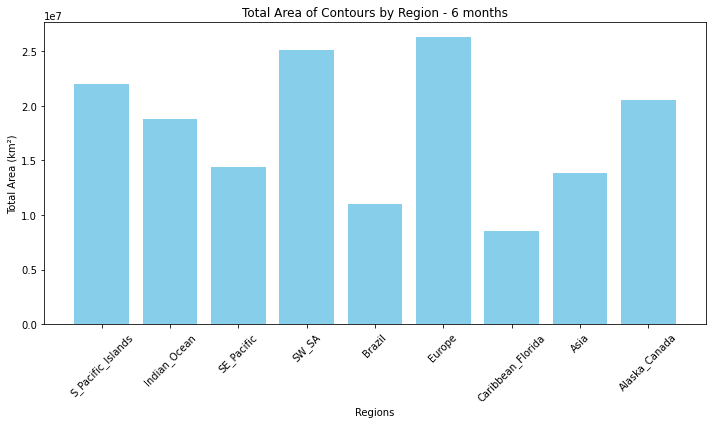

In [145]:
# calculate areas of six month trajectories
area_results = {}
for region, file in dataframes.items():
    total_area = six_area(file)
    area_results[region] = total_area

# create plot
plt.figure(figsize=(10, 6))
plt.bar(area_results.keys(), area_results.values(), color='skyblue')
plt.xlabel('Regions')
plt.ylabel('Total Area (km²)')
plt.title('Total Area of Contours by Region - 6 months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes

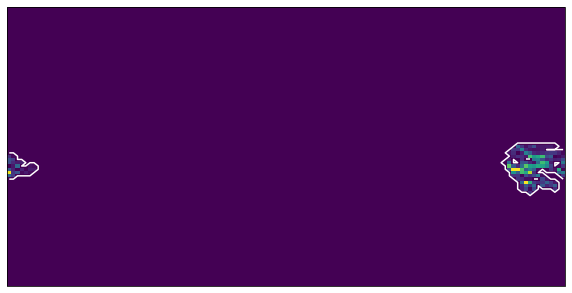

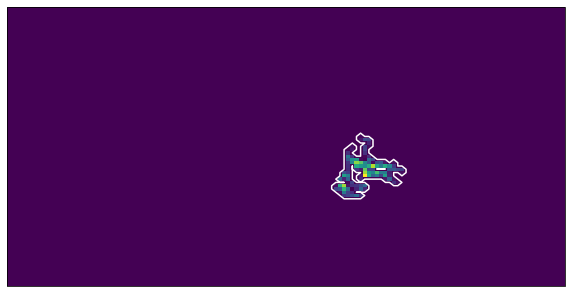

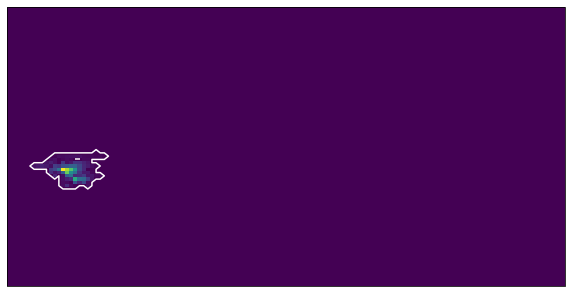

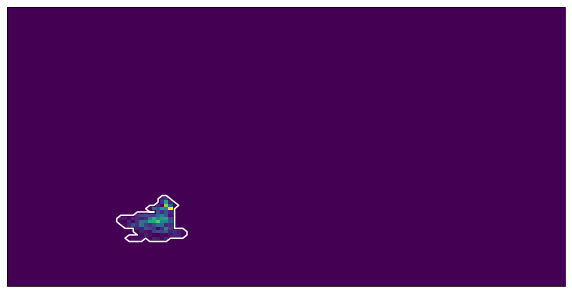

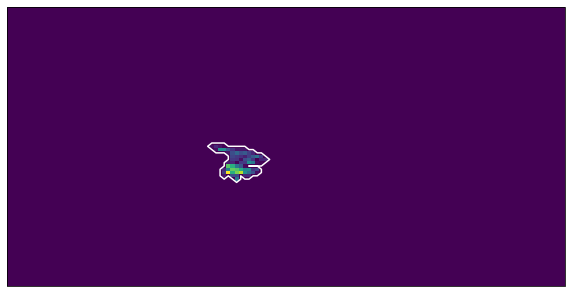

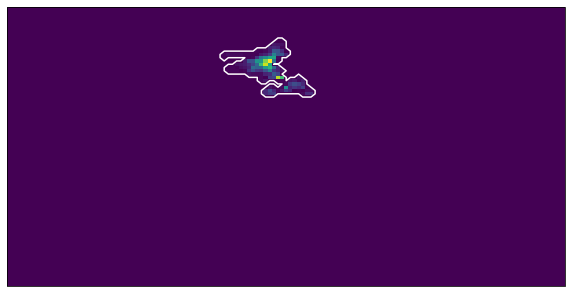

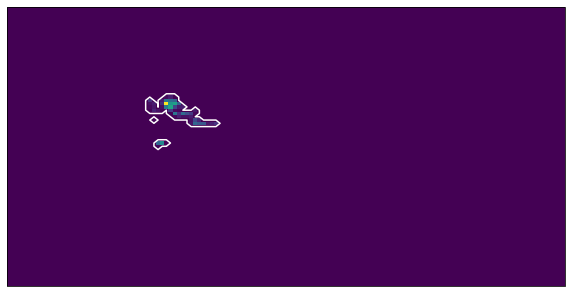

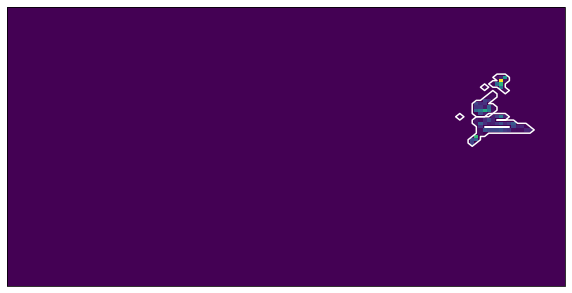

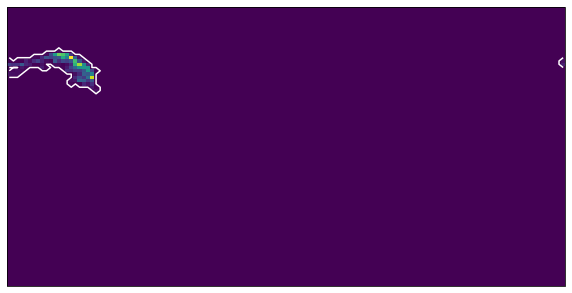

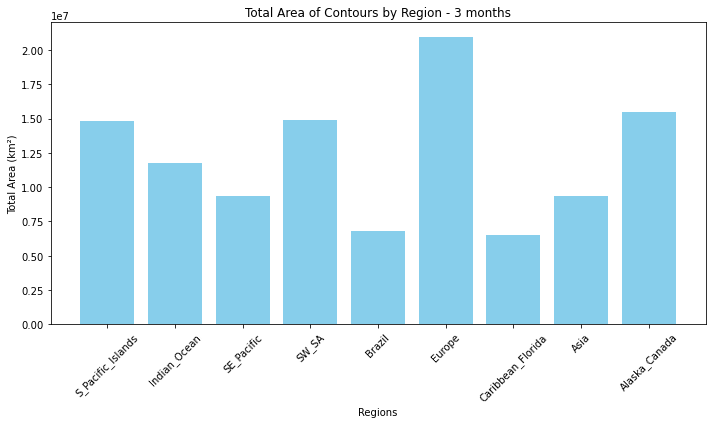

In [146]:
# calculate areas of three month trajectories
area_results = {}
for region, file in dataframes.items():
    total_area = three_area(file)
    area_results[region] = total_area

# create plot
plt.figure(figsize=(10, 6))
plt.bar(area_results.keys(), area_results.values(), color='skyblue')
plt.xlabel('Regions')
plt.ylabel('Total Area (km²)')
plt.title('Total Area of Contours by Region - 3 months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes

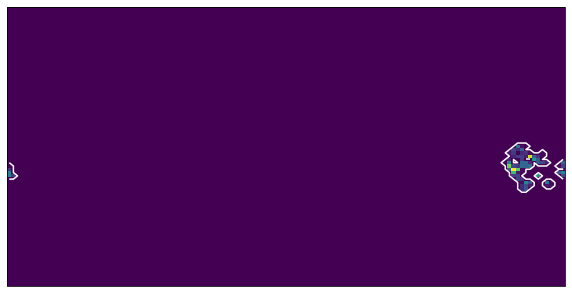

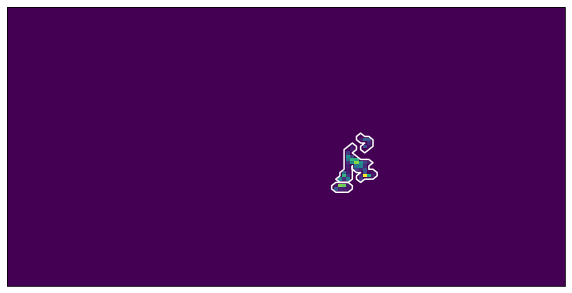

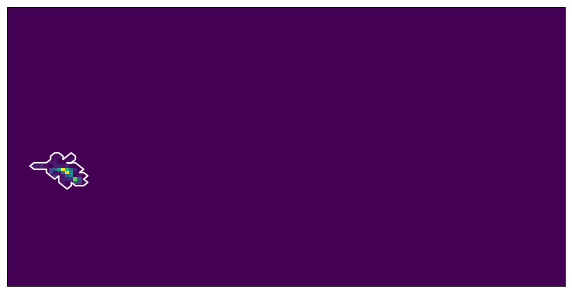

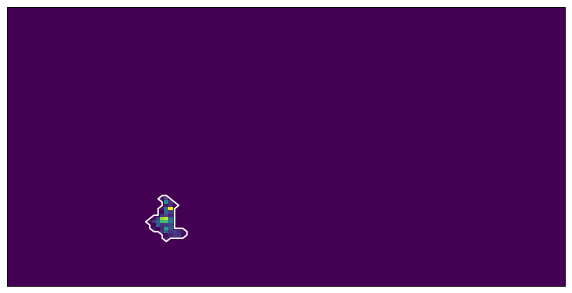

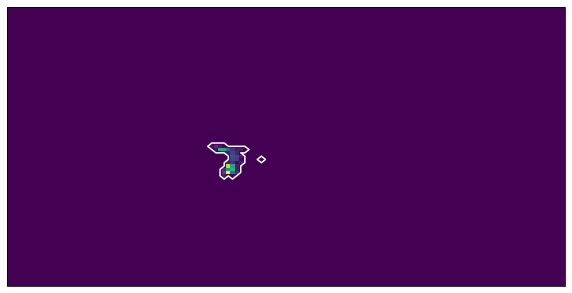

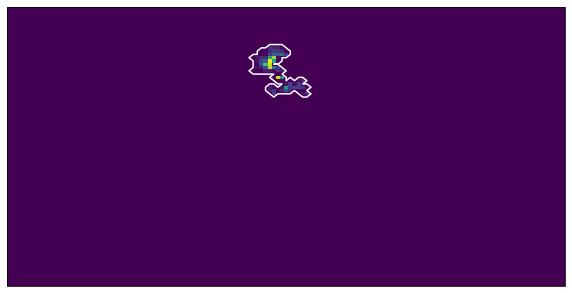

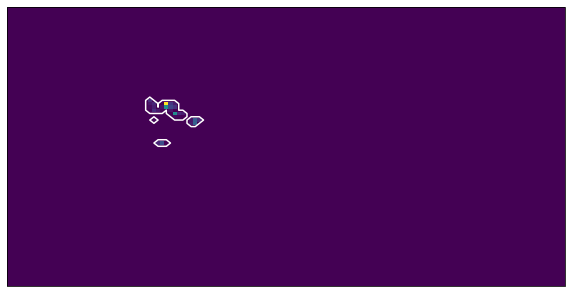

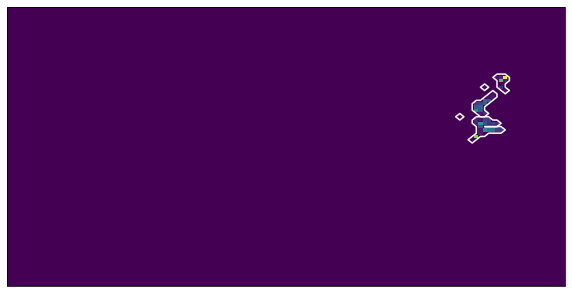

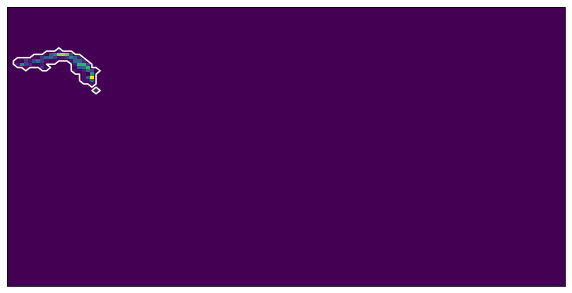

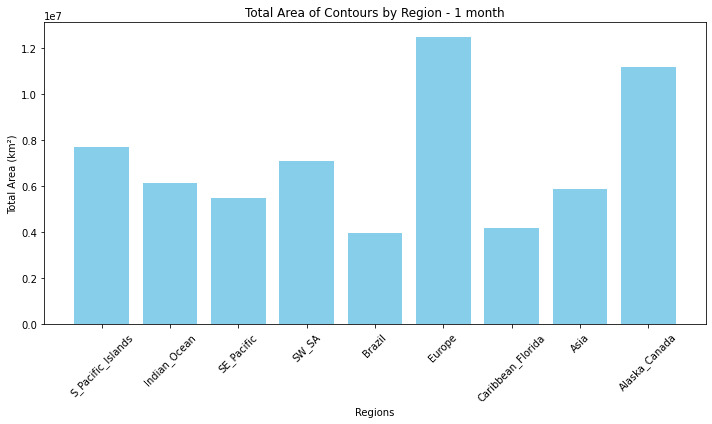

In [147]:
# calculate areas of one month trajectories
area_results = {}
for region, file in dataframes.items():
    total_area = one_area(file)
    area_results[region] = total_area

# create plot
plt.figure(figsize=(10, 6))
plt.bar(area_results.keys(), area_results.values(), color='skyblue')
plt.xlabel('Regions')
plt.ylabel('Total Area (km²)')
plt.title('Total Area of Contours by Region - 1 month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()